# CNN Modeling

***Note that much of the code for different models has been pushed out into markdown cells after having been run. This is due to severe memory bloat issues during training that caused errors to arise during training on the AWS EC2 server. This should also allow the notebook to be run from top to bottom in a timely manner. If you wish to run the previous model iterations or examine them with IDE features on, simply convert them back to code cells.***

In [1]:
# General libraries
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from matplotlib import cm
from mpl_toolkits.axes_grid1 import ImageGrid
import math

# Deep learning libraries
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import PIL



Data is imported from the directory via the below ImageDataGenerator objects. These objects import the images at execution time and convert them to numpy arrays containing scaled pixel values that can be fed into the convolutional neural networks that we are constructing. They also conveniently perform image augmentation at execution time for training images to prevent overfitting, as well as providing a validation split.

The main model we are seeking to develop makes multiclass predictions based on chest x-ray (CXR) images to determine whether a given patient has bacterial pneumonia, viral pneumonia, or if the CXR is negative for pneumonia. 

In [2]:
#Image generators for importing data and providing validation split for training
train_image = ImageDataGenerator(rescale=1/255,
                                 width_shift_range=0.05,
                                 height_shift_range=0.05,
                                 horizontal_flip=True,
                                 shear_range=10,
                                 brightness_range=[0.95,1.05],
                                 validation_split=.2)

#attempting to create validation data set without augmentations applied to the training set
#random seed is set upon generation of the data, thus should prevent data leakage
validation_image = ImageDataGenerator(rescale=1/255,
                                     validation_split=.2)

test_image = ImageDataGenerator(rescale=1/255)

In [3]:
#training data processing
train_gen = train_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    seed=42)

Found 4186 images belonging to 3 classes.


In [4]:
#validation data processing
val_gen = validation_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='validation', interpolation="lanczos",
    seed=42)

Found 1045 images belonging to 3 classes.


In [5]:
#testing data processing
test_gen = test_image.flow_from_directory(
    directory='chest_xray/test', 
    target_size=(128, 128), color_mode='grayscale', 
    batch_size=32, 
    class_mode='categorical', interpolation="lanczos",
    seed=42)

Found 624 images belonging to 3 classes.


#initial model
model = models.Sequential()
model.add(layers.Conv2D(filters=32,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=model_checkpoint_callback)

model.summary()

#2nd model iteration - increased kernel size, added padding
kernel = (8, 8)

model2 = models.Sequential()
model2.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
model2.add(layers.Conv2D(128, kernel, activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, kernel, activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dense(3, activation='softmax'))

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model2.fit(train_gen,epochs=10, validation_data=val_gen, callbacks=model_checkpoint_callback)

model2.summary()

#3rd model iteration - increased pool size
kernel = (8, 8)
pool = (3, 3)

model3 = models.Sequential()
model3.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
model3.add(layers.MaxPooling2D(pool_size=pool))

#hidden layers
model3.add(layers.Conv2D(128, kernel, activation='relu'))
model3.add(layers.MaxPooling2D(pool))
model3.add(layers.Conv2D(128, kernel, activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(3, activation='softmax'))

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model3.fit(train_gen,epochs=10,validation_data=val_gen)

model3.summary()

#4th model iteration - changed activation function for hidden layers to tanh, converted last hidden layer to dropout layer
kernel = (8, 8)
pool = (3, 3)

model4 = models.Sequential()
model4.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model4.add(layers.MaxPooling2D(pool_size=pool))
model4.add(layers.Conv2D(128, kernel, activation='tanh'))
model4.add(layers.MaxPooling2D(pool))
model4.add(layers.Conv2D(128, kernel, activation='tanh'))
model4.add(layers.Flatten())
model4.add(layers.Dense(128, activation='tanh'))
model4.add(layers.Dropout(rate=.25))
#output layer
model4.add(layers.Dense(3, activation='softmax'))

model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model4.fit(train_gen,epochs=10,validation_data=val_gen, callbacks=model_checkpoint_callback)

model4.summary()

#5th model iteration - reverted activation function changes, kept dropout layer
kernel = (8, 8)
pool = (3, 3)

model5 = models.Sequential()
model5.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model5.add(layers.MaxPooling2D(pool_size=pool))
model5.add(layers.Conv2D(128, kernel, activation='relu'))
model5.add(layers.MaxPooling2D(pool))
model5.add(layers.Conv2D(128, kernel, activation='relu'))
model5.add(layers.Flatten())
model5.add(layers.Dense(128, activation='relu'))
model5.add(layers.Dropout(rate=.25))
#output layer
model5.add(layers.Dense(3, activation='softmax'))

#compiling and fitting the model
model5.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model5.fit(train_gen,epochs=10,validation_data=val_gen, callbacks=model_checkpoint_callback)

model5.summary()

#5th model iteration - added 1 extra convlution, reduced kernel size
kernel = (8, 8)
pool = (3, 3)

model6 = models.Sequential()
model6.add(layers.Conv2D(filters=32,
                        kernel_size=kernel,
                        activation='relu',
                        input_shape=(128, 128, 1),
                        padding='valid'))
#hidden layers
model6.add(layers.MaxPooling2D(pool_size=pool))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.MaxPooling2D(pool))
model6.add(layers.Conv2D(128, kernel, activation='relu'))
model6.add(layers.Flatten())
model6.add(layers.Dense(128, activation='relu'))
model6.add(layers.Dropout(rate=.25))
#output layer
model6.add(layers.Dense(3, activation='softmax'))

#compiling and fitting the model
model6.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model6.fit(train_gen,epochs=20,validation_data=val_gen, callbacks=model_checkpoint_callback)

model6.summary()

# Larger Image Sizes

Due to the granularity typically involved in human interpretation of Chest X-ray images (i.e. identifying presence and patterns of infiltrate in the lungs) we are experimenting with increasing the size of the images to achieve greater precision. This poses a greater risk of overfitting, and increases training time, however, it is possible that using convolutions and pooling, our model may be able to aggregate and interpret this finer detail if tuned appropriately.

#training data processing using half length and width of original image size
train_gen_0 = train_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(534, 381),color_mode='grayscale',
    batch_size=64, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    seed=42)

#validation data processing using half length and width of original image size
val_gen_0 = validation_image.flow_from_directory(
    directory='chest_xray/train', 
    target_size=(534, 381),color_mode='grayscale',
    batch_size=128, 
    class_mode='categorical', subset='validation', interpolation="lanczos",
    seed=42)

#initial model using half length and width of original image size
model7 = models.Sequential()

#input layer
model7.add(layers.Conv2D(filters=3,
                        kernel_size=(20, 20),
                        activation='swish',
                        input_shape=(534, 381, 1)))
model7.add(layers.Flatten())

#hidden layers
model7.add(layers.Dense(128, activation='swish'))
model7.add(layers.Dense(64, activation='swish'))
model7.add(layers.Dense(32, activation='swish'))

#output layer
model7.add(layers.Dense(3, activation='softmax'))

#compile and compute
model7.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model7.fit(train_gen_0, epochs=20, validation_data=val_gen_0, callbacks=model_checkpoint_callback)

# Deep Models

#Going Deeper
model8 = models.Sequential()

#input layer
model8.add(layers.Conv2D(filters=32,
                        kernel_size=(20, 20),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model8.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layers
model8.add(layers.Conv2D(32, (2, 2), activation='relu'))
model8.add(layers.MaxPooling2D((2, 2)))
model8.add(layers.Conv2D(32, (2, 2), activation='relu'))
model8.add(layers.Flatten())
model8.add(layers.Dense(64, activation='relu'))
model8.add(layers.Dense(32, activation='relu'))
model8.add(layers.Dense(16, activation='relu'))
model8.add(layers.Dense(8, activation='relu'))

#output layer
model8.add(layers.Dense(3, activation='softmax'))

#compile and compute
model8.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model8.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=model_checkpoint_callback)

model8.summary()

#Going Even Deeper
model9 = models.Sequential()

#input layer
model9.add(layers.Conv2D(filters=32,
                        kernel_size=(20, 20),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model9.add(layers.MaxPooling2D(pool_size=(2, 2)))

#hidden layers
model9.add(layers.Conv2D(32, (2, 2), activation='relu'))
model9.add(layers.Flatten())
#dense layers for interpretation
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dropout(.5))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))
model9.add(layers.Dropout(.5))
model9.add(layers.Dense(64, activation=layers.LeakyReLU()))
model9.add(layers.Dense(64, activation='relu'))

#output layer
model9.add(layers.Dense(3, activation='softmax'))

#compile and compute
model9.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints/cp.ckpt",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

model9.fit(train_gen, epochs=50, validation_data=val_gen, callbacks=model_checkpoint_callback)

# Final Multiclass Model

In [6]:
#Went too deep - trying new activation function in hidden layers
model0 = models.Sequential()

#input layer
model0.add(layers.Conv2D(filters=16,
                        kernel_size=(3, 3),
                        activation='relu',
                        input_shape=(128, 128, 1)))
model0.add(layers.MaxPooling2D(pool_size=(3, 3)))

#hidden layers
model0.add(layers.Conv2D(32, (3, 3), activation='swish'))
model0.add(layers.MaxPooling2D((3, 3)))
model0.add(layers.Conv2D(32, (3, 3), activation='swish'))
model0.add(layers.Flatten())
model0.add(layers.Dense(64, activation='swish'))
model0.add(layers.Dense(32, activation='swish'))
model0.add(layers.Dense(16, activation='swish'))
model0.add(layers.Dense(8, activation='swish'))

#output layer
model0.add(layers.Dense(3, activation='softmax'))

#compile and compute
model0.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC'])
#creating a save file for this model
model_checkpoint_callback = ModelCheckpoint(filepath="./Checkpoints/cp.ckpt",
                                           save_weights_only=True,
                                           monitor='val_accuracy',
                                           mode='max',
                                           save_best_only=True)

multi_history = model0.fit(train_gen, epochs=30, validation_data=val_gen, callbacks=model_checkpoint_callback)

Epoch 1/30
131/131 [==============================] - 70s 535ms/step - loss: 0.9114 - accuracy: 0.5717 - auc: 0.7486 - val_loss: 0.7087 - val_accuracy: 0.7062 - val_auc: 0.8805
Epoch 2/30
131/131 [==============================] - 68s 516ms/step - loss: 0.6421 - accuracy: 0.7155 - auc: 0.8828 - val_loss: 0.5722 - val_accuracy: 0.7435 - val_auc: 0.9069
Epoch 3/30
131/131 [==============================] - 69s 527ms/step - loss: 0.5710 - accuracy: 0.7477 - auc: 0.9065 - val_loss: 0.5808 - val_accuracy: 0.7321 - val_auc: 0.9097
Epoch 4/30
131/131 [==============================] - 66s 507ms/step - loss: 0.5632 - accuracy: 0.7547 - auc: 0.9082 - val_loss: 0.5475 - val_accuracy: 0.7493 - val_auc: 0.9140
Epoch 5/30
131/131 [==============================] - 71s 539ms/step - loss: 0.5335 - accuracy: 0.7613 - auc: 0.9180 - val_loss: 0.5308 - val_accuracy: 0.7579 - val_auc: 0.9221
Epoch 6/30
131/131 [==============================] - 71s 545ms/step - loss: 0.5224 - accuracy: 0.7709 - auc: 0.920

# Binary Classification

Link to Binary Classification Repo: https://github.com/StefanoCaruso456/Pediatric_Pneumonia_Binary.git

In [7]:
#see secondary repo - binary classification model adapted from separate repository
#creating image data generators to convert images to numpy pixel arrays
train_image_binary = ImageDataGenerator(rescale=1/255, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
val_image_binary = ImageDataGenerator(rescale=1/255, zoom_range=0.3, vertical_flip=True, validation_split=0.2)
test_image_binary = ImageDataGenerator(rescale=1/255)

In [8]:
#data generators for binary classifier
train_gen_binary = train_image_binary.flow_from_directory(
    directory='CXR_Binary/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='training', interpolation="lanczos",
    shuffle=True,
    seed=42)

val_gen_binary = val_image_binary.flow_from_directory(
    directory='CXR_Binary/train', 
    target_size=(128, 128),color_mode='grayscale',
    batch_size=32, 
    class_mode='categorical', subset='validation',interpolation="lanczos",
    shuffle=True,
    seed=42)

test_gen_binary = test_image_binary.flow_from_directory(
    directory='CXR_Binary/test', 
    target_size=(128, 128),color_mode='grayscale', 
    batch_size=32, 
    class_mode='categorical',interpolation="lanczos",
    shuffle=True,
    seed=42)

Found 4499 images belonging to 2 classes.
Found 1123 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
#Final Binary Model
model_binary = models.Sequential()
model_binary.add(layers.Conv2D(filters=10,
                        kernel_size=(3, 3),
                        activation='swish',
                        input_shape=(128, 128, 1)))
model_binary.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_binary.add(layers.Conv2D(64, (3, 3), activation='swish'))
model_binary.add(layers.MaxPooling2D((2, 2)))
model_binary.add(layers.Conv2D(32, (3, 3), activation='swish'))
model_binary.add(layers.Flatten())
model_binary.add(layers.Dense(16, activation='swish'))
model_binary.add(layers.Dense(2, activation='sigmoid'))

model_binary.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

binary_history = model_binary.fit(train_gen_binary,epochs=30, batch_size=32,validation_data=val_gen_binary)

Epoch 1/30
141/141 [==============================] - 83s 587ms/step - loss: 0.4696 - accuracy: 0.7902 - val_loss: 0.3260 - val_accuracy: 0.8629
Epoch 2/30
141/141 [==============================] - 81s 574ms/step - loss: 0.3758 - accuracy: 0.8464 - val_loss: 0.3118 - val_accuracy: 0.8718
Epoch 3/30
141/141 [==============================] - 80s 565ms/step - loss: 0.3421 - accuracy: 0.8626 - val_loss: 0.3246 - val_accuracy: 0.8700
Epoch 4/30
141/141 [==============================] - 82s 582ms/step - loss: 0.3271 - accuracy: 0.8724 - val_loss: 0.2636 - val_accuracy: 0.8833
Epoch 5/30
141/141 [==============================] - 81s 577ms/step - loss: 0.2902 - accuracy: 0.8737 - val_loss: 0.2253 - val_accuracy: 0.9154
Epoch 6/30
141/141 [==============================] - 81s 578ms/step - loss: 0.2556 - accuracy: 0.8924 - val_loss: 0.1993 - val_accuracy: 0.9190
Epoch 7/30
141/141 [==============================] - 79s 563ms/step - loss: 0.2379 - accuracy: 0.9066 - val_loss: 0.1862 - val_ac

# Evaluation

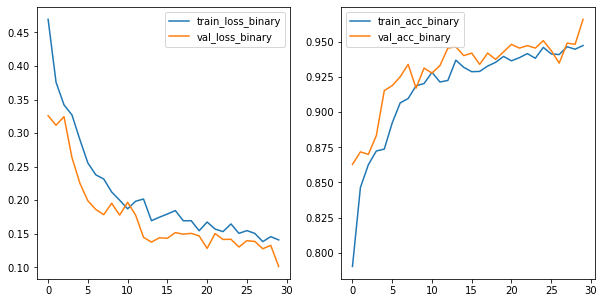

In [10]:
#import library for visuals
import seaborn as sns

#training charts for binary model
train_loss_binary = binary_history.history['loss']
train_acc_binary = binary_history.history['accuracy']
val_loss_binary = binary_history.history['val_loss']
val_acc_binary = binary_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=binary_history.epoch, y=train_loss_binary, ax=ax1, label='train_loss_binary')
sns.lineplot(x=binary_history.epoch, y=train_acc_binary, ax=ax2, label='train_acc_binary')

sns.lineplot(x=binary_history.epoch, y=val_loss_binary, ax=ax1, label='val_loss_binary')
sns.lineplot(x=binary_history.epoch, y=val_acc_binary, ax=ax2, label='val_acc_binary');

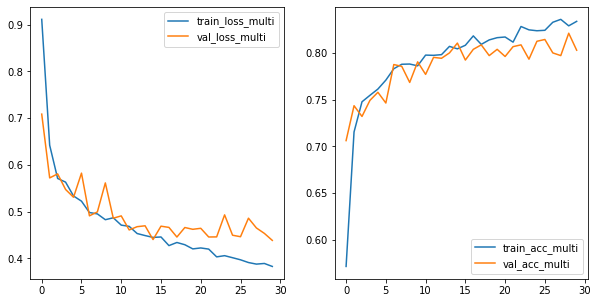

In [13]:
#training charts for multiclass model
train_loss_multi = multi_history.history['loss']
train_acc_multi = multi_history.history['accuracy']
val_loss_multi = multi_history.history['val_loss']
val_acc_multi = multi_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(x=multi_history.epoch, y=train_loss_multi, ax=ax1, label='train_loss_multi')
sns.lineplot(x=multi_history.epoch, y=train_acc_multi, ax=ax2, label='train_acc_multi')

sns.lineplot(x=multi_history.epoch, y=val_loss_multi, ax=ax1, label='val_loss_multi')
sns.lineplot(x=multi_history.epoch, y=val_acc_multi, ax=ax2, label='val_acc_multi');

In [16]:
#pull out test metrics
test_loss_binary, test_acc_binary = model_binary.evaluate(test_gen_binary)
test_loss_multi, test_acc_multi, test_auc = model0.evaluate(test_gen)

20/20 [==============================] - 6s 291ms/step - loss: 0.5211 - accuracy: 0.8429 - auc: 0.9381


In [18]:
#prediction probabilities
y_binary = model_binary.predict(test_gen_binary)
y_multi = model0.predict(test_gen)

In [76]:
y_multi

array([[1.2255161e-02, 9.6752071e-01, 2.0224070e-02],
       [8.6402136e-01, 6.5338216e-05, 1.3591331e-01],
       [9.2826909e-01, 2.8434463e-04, 7.1446575e-02],
       ...,
       [1.6729881e-01, 1.0753628e-02, 8.2194757e-01],
       [3.5779804e-04, 9.8452860e-01, 1.5113576e-02],
       [1.7799747e-03, 9.9067211e-01, 7.5478996e-03]], dtype=float32)

# Sample Image to demonstrate use of probabilities, etc.

In [79]:
#sample image import
sample_gen = test_image.flow_from_directory(
    directory='chest_xray/sample', 
    target_size=(128, 128), color_mode='grayscale', 
    batch_size=1, 
    class_mode='categorical', interpolation="lanczos",
    seed=42)

Found 1 images belonging to 3 classes.


In [80]:
model0.predict(sample_gen)

array([[9.7109210e-01, 1.7016632e-07, 2.8907839e-02]], dtype=float32)

In [81]:
import matplotlib.image as mpimg

In [83]:
img = mpimg.imread("./chest_xray/sample/BACTERIA/BACTERIA-2034017-0005.jpeg")

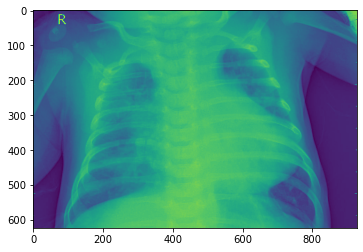

In [84]:
plt.imshow(img)